**Multi-Class Text Classification Job title by industry**


In [403]:
#Import libraries 

# basic lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# nlp preprocessing lib
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import string 
punctation = string.punctuation 

## Load Data

In [404]:
#loading data into a pandas.DataFrame as dataset.
dataset = pd.read_csv("./sample_data/Job titles and industries.csv")
dataset.sample(5)

,job title,industry
1128,senior react developer,IT
3146,automation test engineer - dv cleared,IT
635,full stack developer - educational technology ...,IT
6208,life science communications executive,Marketing
5273,marketing database coordinator,Marketing


### EDA on Data

In [380]:
# As we see blow two columns of type object and contains 8585 entries
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


In [381]:
#Each job title belongs to one of industry types. 
#The industry type is the classes or predictions and the job titles are our feartures.
classes = np.array(dataset['industry'].unique())
job_titles =  np.array(dataset['job title'].unique())
print("There are {} unique Classes in the dataset: {}".format(len(classes), classes))
print("\nThere are {} unique job titles entries in dataset like: \n{}.".format(len(job_titles), job_titles[:3]))


There are 4 unique Classes in the dataset: ['IT' 'Marketing' 'Education' 'Accountancy']

There are 3890 unique job titles entries in dataset like: 
['technical support and helpdesk supervisor - county buildings, ayr soa04086'
 'senior technical support engineer' 'head of it services'].


### Visualize the distribution of classes.

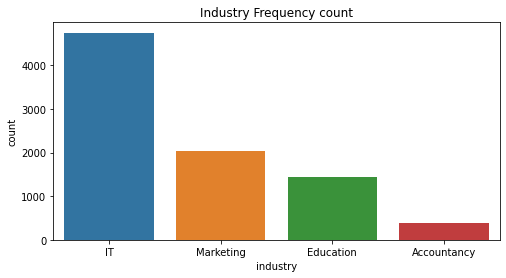

In [382]:
# Show Industry Frequency count
plt.figure(figsize=(8,4))
plt.title("Industry Frequency count")
sns.countplot(x = 'industry', data = dataset)

### Cleaning the data: Handling duplicates

In [383]:
#Detect duplicate in data 4618 row duplicates in job title per industry
dataset[dataset.duplicated()].head()

,job title,industry
7,devops engineers x 3 - global brand,IT
10,devops engineers x 3 - global brand,IT
11,devops engineers x 3 - global brand,IT
26,business analyst,IT
36,.net developer,IT


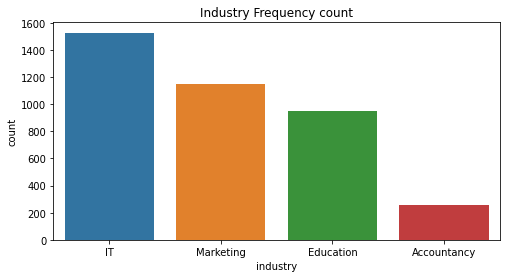

In [384]:
#Drop Duplicated rows 
dataset_cleaned = dataset.drop_duplicates(subset="job title")
# Show Industry Frequency count after remove duplicates
plt.figure(figsize=(8,4))
plt.title("Industry Frequency count")
sns.countplot(x = 'industry', data = dataset_cleaned)


### Text Preprocessing

In [385]:
# take text and preprocess 'remove stopwords [a, the, and, thus, ... etc] and punctations[,%$ ..etc] and len of text less than 3' 
def clean_text(text):
    """
        text: a string 
        return: cleaned string
    """
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in punctation and  len(token) >= 3 :
            token = token.lower() 
            result.append(token)    
    return " ".join(result)


In [386]:
dataset_cleaned['job title'] = dataset_cleaned['job title'].map(clean_text)
dataset_cleaned.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,job title,industry
0,technical support helpdesk supervisor county b...,IT
1,senior technical support engineer,IT
2,head services,IT
3,end engineer,IT
4,network telephony controller,IT


### Splitting data into test and train datasets + Dealing with class imbalance

In [387]:
X = dataset_cleaned['job title']
y = dataset_cleaned['industry']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
weights = compute_sample_weight("balanced",y_train)

## The Model 

### Approach 1: Naive Bayes classifier for multinomial models

In [388]:
from sklearn.model_selection import cross_val_score
nb_classifier = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])

nb_classifier.fit(X_train, y_train, **{'clf__sample_weight': weights})
y_pred = nb_classifier.predict(X_test)
print('accuracy {}'.format(accuracy_score(y_pred, y_test)))

accuracy 0.8774635818337618


### Approach 2: Linear SVM GradientDesent

In [399]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='epsilon_insensitive', penalty='l2',alpha=1e-3, random_state=42, max_iter=1000, tol=None)),])


sgd.fit(X_train, y_train, **{'clf__sample_weight': weights})
y_pred = sgd.predict(X_test)
print('accuracy {}'.format(accuracy_score(y_pred, y_test)))

accuracy 0.895458440445587


In [400]:
sgd.predict(['NLP Engineer'])

array(['IT'], dtype='<U11')

In [401]:
sgd.predict(['Chief marketing officer'])

array(['Marketing'], dtype='<U11')

In [402]:
confusion_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

TypeError: ignored

### Evaluating using F1-score for classes 

In [393]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

          IT       0.72      0.83      0.77        76
   Marketing       0.96      0.89      0.92       274
   Education       0.95      0.88      0.91       486
 Accountancy       0.83      0.93      0.88       331

    accuracy                           0.89      1167
   macro avg       0.86      0.88      0.87      1167
weighted avg       0.90      0.89      0.90      1167



### Save the final selected Model to a file to use directly in the RESTfull API script.

In [394]:
from joblib import dump, load
dump(sgd, 'model.joblib')

['model.joblib']